##### 70/30 - M1 XGBoost = *46.85%* , M2 SVM = *75.50%* , M3 = (70/30) 4L - 37.75(Adadelta) , 38.74(Adam), (3L - 38.25) , 
M4 = (80/20) - 3L = 37.64 % , (4L - 36.6%),

#Preparing the Dataset

In [5]:
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import os
from tqdm import tqdm
import math
import json

In [ ]:
# #Testing single wav audio file 
# data_path = "/content/drive/MyDrive/HMR_1.0/audio/01_20001_02_Raag_Multani.wav"
# signal , sr = librosa.load(data_path)
# # print(signal.size)
# # signal = signal[:SAMPLES_PER_TRACK]
# # print(signal.size)

In [ ]:
# cqt = librosa.cqt(y=signal,sr=sr,hop_length = 512)[0]
# cqt = np.abs(cqt)
# cqt

array([1.1743161e-05, 2.1575574e-05, 3.8613460e-05, ..., 3.1245861e-06,
       1.0712529e-06, 4.1646260e-07], dtype=float32)

In [ ]:
sbrf = librosa.feature.spectral_rolloff(y=signal,sr=sr,n_fft = 1024, hop_length=512)[0]
sbrf.shape

(5168,)

In [ ]:
scb = librosa.feature.spectral_bandwidth(y=signal,sr=sr,n_fft = 1024, hop_length=512)[0]
scb.shape

(5168,)

In [ ]:
sc = librosa.feature.tonnetz(y=signal,sr=sr,hop_length =512)[0]
sc.shape

(5168,)

In [ ]:
scn = librosa.feature.zero_crossing_rate(y=signal,frame_length=1024,hop_length=512)[0]
scn.shape

(5168,)

In [ ]:
scnt = librosa.feature.rms(y=signal,frame_length=1024,hop_length=512)[0]
scnt.shape

(5168,)

In [ ]:
sc = librosa.stft(y=signal,n_fft = 2048, hop_length=512)[0]
y_scale = np.abs(sc)**2
log_yscale = librosa.power_to_db(y_scale)
# log_mel_spectrogram = librosa.power_to_db(sc)[0]
# log_mel_spectrogram=log_mel_spectrogram.T

In [ ]:
log_yscale.shape

(5168,)

In [ ]:
sr

22050

In [25]:
#Loading of HMR dataset 
dataset_path='HMR_1.0\audio'
df=pd.read_excel('HMR_1.0\HMR_dataframe.xlsx')
df.head()

,SL. No.,Name,Taal
0,1,01_21001_1_03_Raga_-_Bilaskhani_Todi,ektaal
1,2,02_21002_1_01_Raga_Ahiri_Todi,ektaal
2,3,03_21003_1_01_Raga_Maru_Bihag,ektaal
3,4,04_21004_3_02_Raga_Darbari_Kanada,ektaal
4,5,05_21005_1_01_Raga_Deshi,ektaal


In [10]:
JSON_PATH = "Data_feature_MFCC.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 120 
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [11]:
data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

In [12]:
taal = {
    "rupaktaal" : 0,
    "teentaal" : 1,
    "jhaptaal" : 2,
    "ektaal" : 3
}

In [13]:
for i in taal.keys():
    
    data["mapping"].append(i)

In [14]:
print(data)

{'mapping': ['rupaktaal', 'teentaal', 'jhaptaal', 'ektaal'], 'labels': [], 'mfcc': []}


In [15]:
def cut_if_necessary(signal):
  signal = signal[:SAMPLES_PER_TRACK]
  return signal

In [16]:
from librosa.util import fix_length

def pad_if_necessary(signal,sr):
  padded_signal = fix_length(signal, size = 120*sr)
  return padded_signal

In [ ]:
import math
SAMPLE_RATE = 22050
TRACK_DURATION = 120 
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
#n_mfcc=13
n_fft=1024
hop_length=512
num_segments=20
  
samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

In [ ]:
print(num_mfcc_vectors_per_segment)
print(samples_per_segment)

259
132300


In [17]:
data

{'mapping': ['rupaktaal', 'teentaal', 'jhaptaal', 'ektaal'],
 'labels': [],
 'mfcc': []}

In [18]:
import gc
gc.collect()

70272

In [27]:
n_mfcc=200
n_fft=2048
hop_length=512
num_segments=40
  
samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)


for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(dataset_path,str(row["Name"])+'.wav')
    final_class_labels=row["Taal"]
    print("\nProcessing: {}".format(final_class_labels))


    signal, sr = librosa.load(file_name,sr=SAMPLE_RATE)

    if(signal.size > SAMPLES_PER_TRACK):
        signal = cut_if_necessary(signal)

    elif(signal.size < SAMPLES_PER_TRACK):
        signal = pad_if_necessary(signal,sr)

    else:
        pass


    for i in range(num_segments):
        

        start = samples_per_segment * i
        finish = start + samples_per_segment
        
        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T

      # mfcc = librosa.feature.zero_crossing_rate(y=signal[start:finish],sr=sr,n_fft=n_fft,hop_length=hop_length)[0]
      # log_mspec = librosa.power_to_db(mfcc)
      # mfcc = librosa.feature.zero_crossing_rate(y=signal[start:finish],frame_length=1024,hop_length=512)[0]
      # mfcc = librosa.feature.rms(y=signal[start:finish],frame_length=1024,hop_length=512)[0]
      # mfcc = librosa.feature.tonnetz(y=signal[start:finish],sr=sr,hop_length=hop_length)[0]
      # mfcc = librosa.feature.spectral_bandwidth(y=signal[start:finish],sr=sr,n_fft = 1024, hop_length=512)[0]
      # mfcc = librosa.feature.spectral_rolloff(y=signal[start:finish],sr=sr,n_fft = 1024, hop_length=512)[0]
#       cqt = librosa.cqt(y=signal[start:finish],sr=sr,hop_length = 512)[0]
#       cqt = np.abs(cqt)
#       mfcc = cqt.T

    


        if len(mfcc) == num_mfcc_vectors_per_segment:
            
            data["mfcc"].append(mfcc.tolist())
            data["labels"].append(taal[final_class_labels])
            print("{}, segment:{}".format(file_name, i+1))


0it [00:00, ?it/s]C:\Users\DSAI\AppData\Local\Temp\ipykernel_20772\3919217910.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_name,sr=SAMPLE_RATE)
0it [00:00, ?it/s]


Processing: ektaal


OSError: [Errno 22] Invalid argument: 'HMR_1.0\x07udio\\01_21001_1_03_Raga_-_Bilaskhani_Todi.wav'

In [ ]:
with open(JSON_PATH, "w") as fp:
  json.dump(data, fp, indent=4)

#ANN 

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:
DATA_PATH = "/content/drive/MyDrive/HMR_1.0/data_10.json"

In [ ]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return X, y

In [ ]:
X.size

10168340

In [ ]:
y.size

3020

In [ ]:
X.shape[1]

259

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

Data succesfully loaded!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3367)              0         
                                                                 
 dense (Dense)               (None, 512)               1724416   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (N

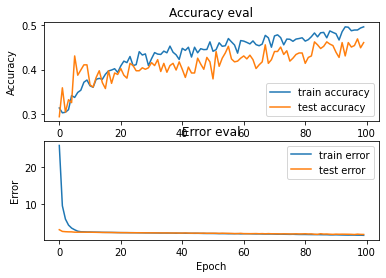

In [ ]:
X, y = load_data(DATA_PATH)

    # create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(4, activation='softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

# plot accuracy and error as a function of the epochs
plot_history(history)

#XGBoost

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

In [ ]:
X, y = load_data(DATA_PATH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Data succesfully loaded!


In [ ]:
X_train.shape

(2416, 3367)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
model = XGBClassifier(learning_rate=0.001,eval_metric=mean_absolute_error)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function mean_absolute_error at 0x7f2115d72940>,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 46.85%


#SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
X, y = load_data(DATA_PATH)

Data succesfully loaded!


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [ ]:
svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.17%
